# Did they receive a flu vaccine?
by Michael Kearns

# Business Understanding

The company is prepping for the upcoming flu season. The production team wants to determine how many vaccines they need to produce to avoid over spending and reduce waste. To determine this, the plan is to gather information from a sample of individuals and classify how many of them will receive the vaccine. Previous data has been gathered on indiviauls with different behaviors and beliefs and whether they had received the flu vaccine in the past. By building a classification model on the previous data, this model can be used to make future classifications and predictions.

# Data Understanding

After the outbreak of the H1N1 virus, the United states conducted the National 2009 H1N1 Flu Survey. This data collected whether individuals received the H1N1 or seasonal flu vaccine as well as information on their backgrounds and health behaviors. For the purpose of this model, the data will only be used to classify if someone received the seasonal flu vaccine. 

Features of this data are primarily formatted in a binary fasion, where 1 - 'Yes' and 0 - 'No'. Multiple features are object type that will require dummy variables or one hot encoding to be considered in the model.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np 

In [2]:
#Data source provided two .csv files. 
#The 'training_set_labels.csv' contains the target value, whether a person recevied the seasonal flu vaccine
#The 'training_set_features.csv' contains the multiple features about each respondent.

train_set_features = 'data/training_set_features.csv'
train_set_labels = 'data/training_set_labels.csv'

In [3]:
#Create dataframe from each .csv file.

features = pd.read_csv(train_set_features)
labels = pd.read_csv(train_set_labels)

#combine into single dataset
df = labels.merge(features,how = 'outer', on = 'respondent_id')

In [30]:
#Remove columns related to H1N1. Business problem is to focus on flu vaccine data.
h1n1_cols_delete = ['h1n1_concern','h1n1_knowledge', 
               'doctor_recc_h1n1',
               'opinion_h1n1_vacc_effective', 
               'opinion_h1n1_risk',
               'opinion_h1n1_sick_from_vacc',
                'h1n1_vaccine']
               

data_flu = df.drop(h1n1_cols_delete, axis = 1)

The dataset includes responses from 26,707 people. Some features are missing data and those will be dropped so the model does not fit to extra noise. There are also senstive features that describe the respondent's race, age, income, education background, etc. These sensitive features will not be included so that model is only fitting on the respndent's opinions and health beahviors. 

In [6]:
#Remove sensitive features from dataset
cols_sensitive = list(data_flu.columns)[17:]
data_flu_clean = data_flu.drop(cols_sensitive,axis = 1)

In [7]:
#Determine which features are missing a lot of data and remove feature from dataset.
data_flu_clean.isna().mean()
data_flu_clean2 = data_flu_clean.drop('health_insurance',axis = 1)

In [8]:
#Remove rows that is missing data.
data_cleaned = data_flu_clean2.dropna(axis = 0)

23,188 responses are leftover after cleaning the data. 13 features will be useable for the classification models. 

# Exploratory Data Analysis

In [10]:
import matplotlib.pyplot as plt

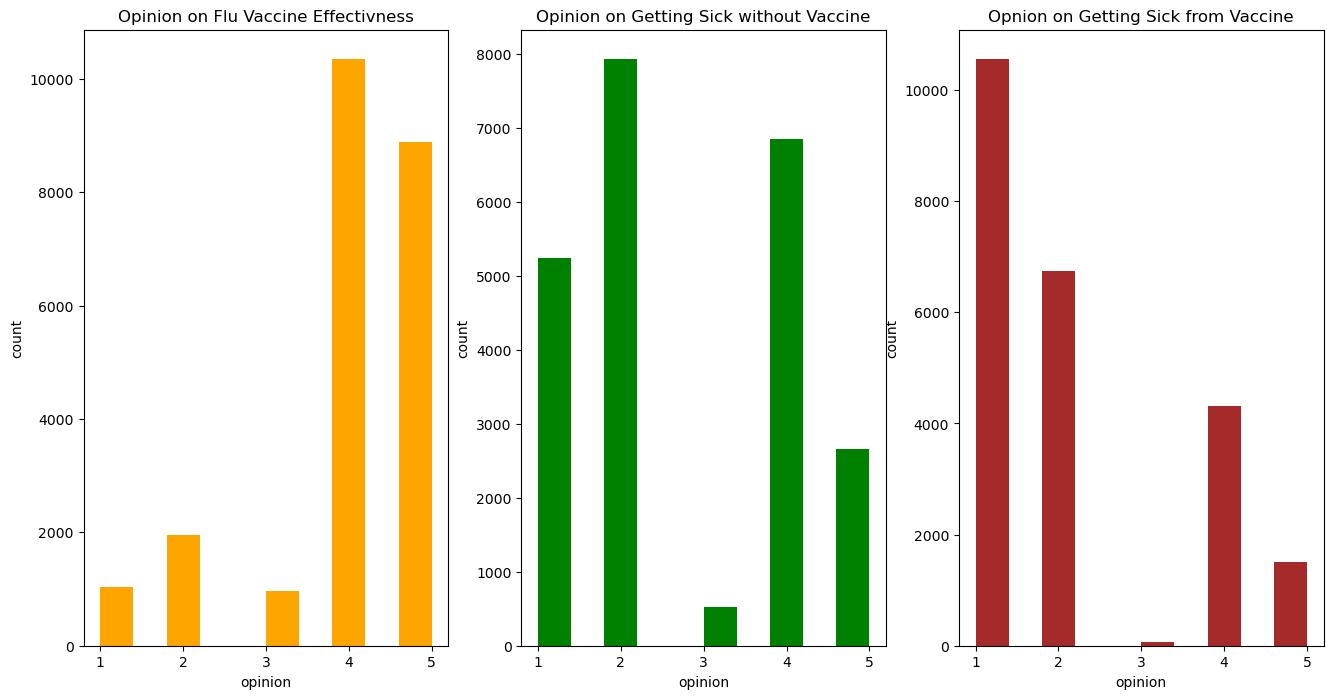

In [31]:
#Plot histogram of respondent's opinions to verify data is variable
health_opinions = ['opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc']
colors = ['orange','green','brown']
opinions = ['Opinion on Flu Vaccine Effectivness',
            'Opinion on Getting Sick without Vaccine',
            'Opnion on Getting Sick from Vaccine']

j = len(health_opinions)
fig, axes = plt.subplots(1,j,figsize = (16,8))
for i in range(0,j):
    axes[i].hist(data_cleaned[health_opinions[i]],color = colors[i])
    axes[i].set_title(opinions[i])
    axes[i].set_ylabel('count')
    axes[i].set_xlabel('opinion')

In [12]:
#Mean reponses for each opinion.
print(data_cleaned[health_opinions].mean())

opinion_seas_vacc_effective    4.038166
opinion_seas_risk              2.730680
opinion_seas_sick_from_vacc    2.115577
dtype: float64


<br>
People's opinions about the seasonal flu vaccine appears to be variable. Therefore this will be a good feature to use in the ML model.
<br>
<br>
The average opinion on the flu vaccine effectiveness is 4.03 - "somewhat effective"
<br>
The average opinion on risk of getting sick without flu vaccine is 2.73 - "somewhat low" to "don't know"
<br>
The everage opinion on getting sick from taking the flu vaccine is 2.12 - "somewhat low"

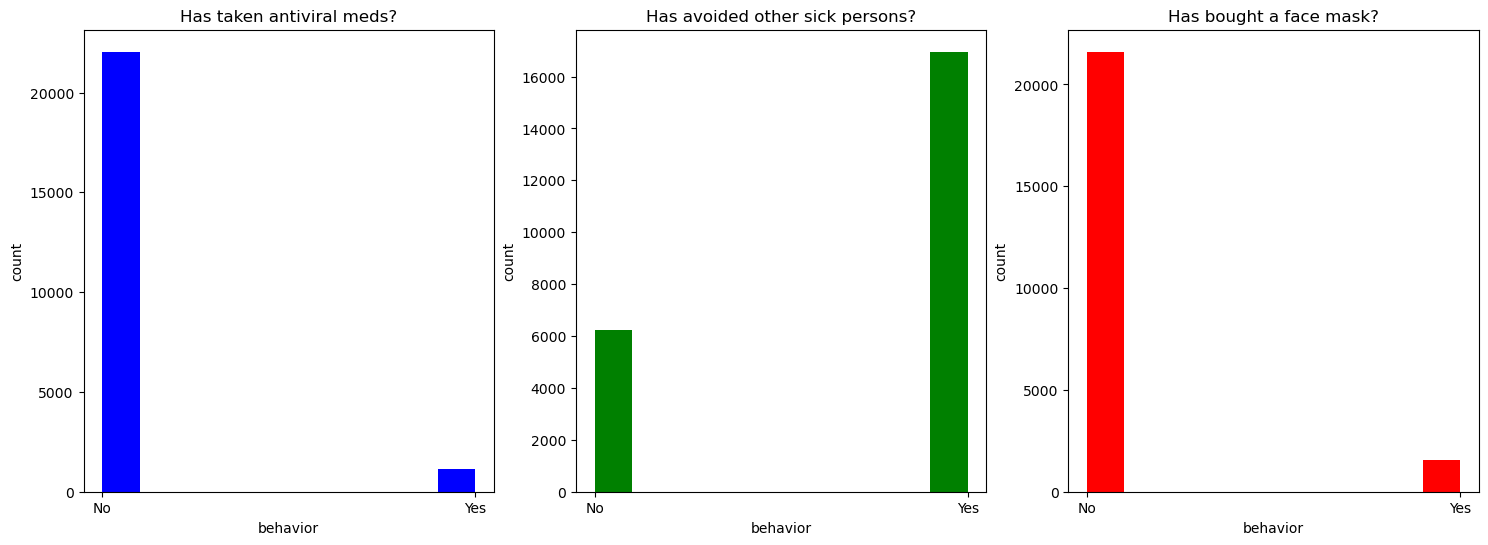

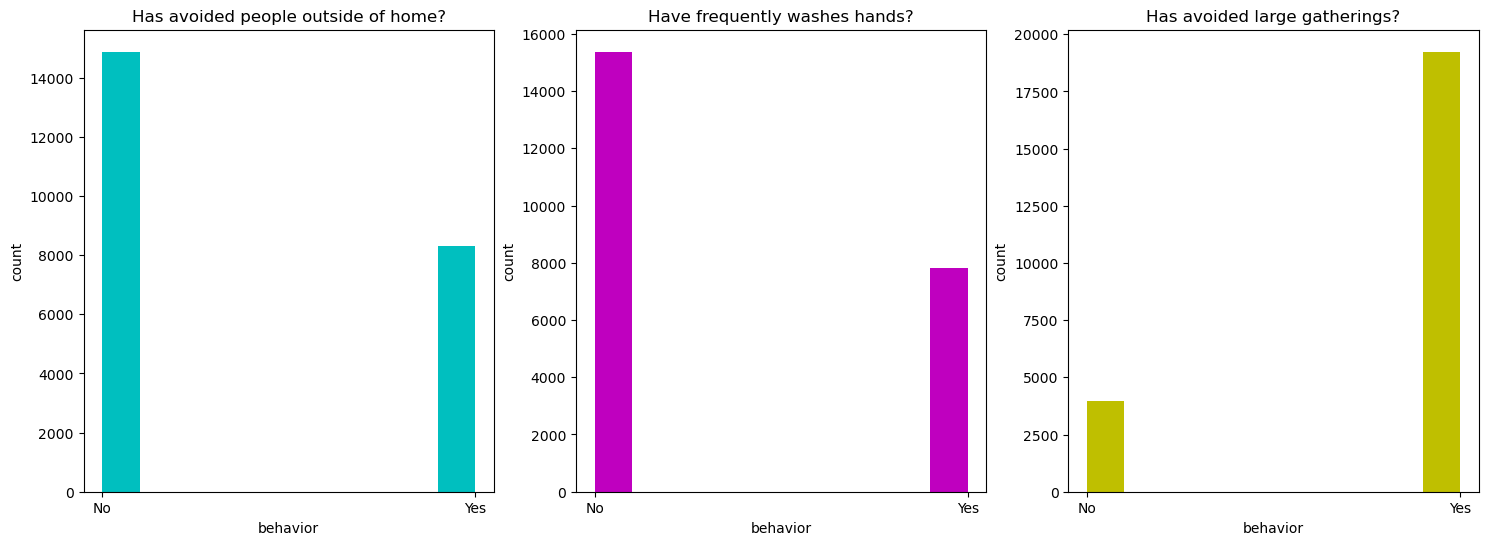

In [13]:
#Plot histogram of respondent's behaviors to verify data is variable
health_behaviors = data_cleaned.columns.tolist()[2:8]
colors = ['b','g','r','y','c','m']
fig, axes = plt.subplots(1,3,figsize = (18,6))
behaviors = ['Has taken antiviral meds?',
             'Has avoided other sick persons?',
             'Has bought a face mask?',
             'Has avoided large gatherings?',
             'Has avoided people outside of home?',
             'Have frequently washes hands?']
             
for i in range(0,3):
    axes[i].hist(data_cleaned[health_behaviors[i]],color = colors[i])
    axes[i].set_title(behaviors[i])
    axes[i].set_ylabel('count')
    axes[i].set_xlabel('behavior')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['No','Yes'])
fig, axes = plt.subplots(1,3,figsize = (18,6))
for i in range(3,6):
    axes[i-4].hist(data_cleaned[health_behaviors[i]],color = colors[i])
    axes[i-4].set_title(behaviors[i])
    axes[i-4].set_ylabel('count')
    axes[i-4].set_xlabel('behavior')
    axes[i-4].set_xticks([0,1])
    axes[i-4].set_xticklabels(['No','Yes'])

In [49]:
#Percent responses to each behavior.
behavior_means = round(data_cleaned[health_behaviors].mean()*100,2).values.tolist()

print("Percent 'Yes' from Respondents Health Beahviors: \n")
for i in range(0,len(behavior_means)):
    print(behaviors[i],behavior_means[i],"%")

Percent 'Yes' from Respondents Health Beahviors: 

Has taken antiviral meds? 4.93 %
Has avoided other sick persons? 73.12 %
Has bought a face mask? 6.81 %
Has avoided large gatherings? 82.95 %
Has avoided people outside of home? 35.83 %
Have frequently washes hands? 33.69 %


People's health behaviors tend to lean more towards one action than the other. This will still be an interesting feature to include.

# ML Modeling

### Target

The goal of this model is to be able to classify whether an individual will receive the seasonal flu vaccine based on their health behaviors and opinions. This information will help the company determine how many vaccines to produce. From this model, a 'False Positive' would represent identifying someone that will choose to receive the vaccine but in fact they do not. A 'False Negative' would represent identifying someone that will choose to not receive the vaccine but they do receive it. It may be costly to over produce vaccines, but there is a greater social and medical impact if there are not enough vaccines for those who choose to receive one. Therefore, minimizing the number of 'False Negatives' is important and Recall will the evaluation metric used for this model

In [52]:
#Check if there is an imbalance in target values

print(data['seasonal_vaccine'].value_counts())
print('\nNo class imbalance in target value. Do not need to weight class differently.')

seasonal_vaccine
0    12111
1    11077
Name: count, dtype: int64

No class imbalance in target value. Do not need to weight class differently.


### Dummy Variables 

The health behaviors and opinions uses numbers but they represent actions and opinions and therefore are still considered categorical data. These columns need dummy variables so that all features have binary responses, 0 or 1. 

In [14]:
#create dummy variables for categorical data

data = pd.get_dummies(data_cleaned,columns = health_opinions,drop_first=True,dtype=float)


## Baseline Model - Logistic Regression Model

In [16]:
#import train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

#define independent and dependent variables
X = data[data.columns.to_list()[2:]]
y = data['seasonal_vaccine']

/Users/michaelkearns/anaconda3/envs/my-learn-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
#perform split with sklearn train_test_split
#Set a random state, and assign 80% of date to test group.

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42,test_size = 0.8)

In [18]:
#import Logistic Regression from scikit-learn
from sklearn.linear_model import LogisticRegression

#instantiate baseline model
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')

#fit to train data
logreg.fit(X_train, y_train)


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [19]:
#Generate predictions on train and test data
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)


In [20]:
#import recall score function from scikit-learn
from sklearn.metrics import recall_score

#calculate recall score on training and test data
print('Baseline - Training Recall: ', recall_score(y_train, y_hat_train))
print('Baseline - Testing Recall: ', recall_score(y_test, y_hat_test))

Baseline - Training Recall:  0.7391304347826086
Baseline - Testing Recall:  0.7429346597332127


Recall numbers on Training data and testing data are similar. This shows that the model is not overfitting to the training data. Ideally though the model performs better with better recall values. A 74% recall number means that of all the people who received the flu vaccine, 74% of them were correctly identified. 

In [21]:
#Cross Validate Baseline Model
#import cross_val_score from scikit-learn
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(logreg,X_train,y_train,scoring = 'recall')

print(f'Baseline Model Average Cross Validation Scores: {cv_scores.mean()}')

Baseline Model Average Cross Validation Scores: 0.7315155345552311


The Baseline training recall and averag cross validation score are similar. This shows the model is generalizing well. 

### Model 2 - Decision Tree

In [22]:
#import Decision Tree function from scikit-learn
from sklearn.tree import DecisionTreeClassifier 

#instiate decision tree with random state and fit to training data
dtc = DecisionTreeClassifier(random_state = 10)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

In [23]:
#Generate predictions on train and test data
y_hat_train = dtc.predict(X_train)
y_hat_test = dtc.predict(X_test)

#calculate recall score on training and test data
print('Decision Tree - Training Recall: ', recall_score(y_train, y_hat_train))
print('Decision - Testing Recall: ', recall_score(y_test, y_hat_test))

Decision Tree - Training Recall:  0.8323621694307486
Decision - Testing Recall:  0.658376667420303


The Decision tree model improved on the training data, but was worse on the test data. This shows that model is overfitting to the training data and cannot predict as well on the test data.

In [24]:
#Cross Validate Decision Tree Model
cv_scores = cross_val_score(dtc,X_train,y_train,scoring = 'recall')

print(f'Decision Tree Average Cross Validation Scores: {cv_scores.mean()}')

Decision Tree Average Cross Validation Scores: 0.6503977688827359


The model training recall is slightly better than the validation score. This shows that the decision tree model is overfit slightly, and there is some noise in the data that model is training on. This model also has lots of layers, it appears to be overly complex and simplifying the model/tuning the parameters can improve overfitting.

### Model 3 - TUNED DECISION TREE

In [25]:
#Check for optimal values of parameters to set in the Decision Tree Model

#Check Optimal depth
dt_depth = dtc.tree_.max_depth

max_depth = list(range(1, dt_depth))
depth_train_results = []
depth_test_results = []
for depth in max_depth:
    
    dt = DecisionTreeClassifier(max_depth=depth, random_state=10)
    dt.fit(X_train,y_train)
    #Test Results
    test_y_pred = dt.predict(X_test)
    test_recall = recall_score(y_test, test_y_pred)
    depth_test_results.append(test_recall)
    #Train Results
    train_y_pred = dt.predict(X_train)
    train_recall = recall_score(y_train, train_y_pred)
    depth_train_results.append(train_recall)

#Check the optimal min-samples-split for given data
sample_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
splits_train_results = []
splits_test_results = []

for num in sample_splits:
    dt = DecisionTreeClassifier(min_samples_split=num, random_state=10)
    dt.fit(X_train,y_train)
    #Test Results
    test_y_pred = dt.predict(X_test)
    test_recall = recall_score(y_test, test_y_pred)
    splits_test_results.append(test_recall)
    #Train Results
    train_y_pred = dt.predict(X_train)
    train_recall = recall_score(y_train, train_y_pred)
    splits_train_results.append(train_recall)

#Check the optimal value for minimum sample leafs
sample_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
leafs_train_results = []
leafs_test_results = []

for num in sample_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=num, random_state=10)
    dt.fit(X_train,y_train)
    #Test Results
    test_y_pred = dt.predict(X_test)
    test_recall = recall_score(y_test, test_y_pred)
    leafs_test_results.append(test_recall)
    #Train Results
    train_y_pred = dt.predict(X_train)
    train_recall = recall_score(y_train, train_y_pred)
    leafs_train_results.append(train_recall)

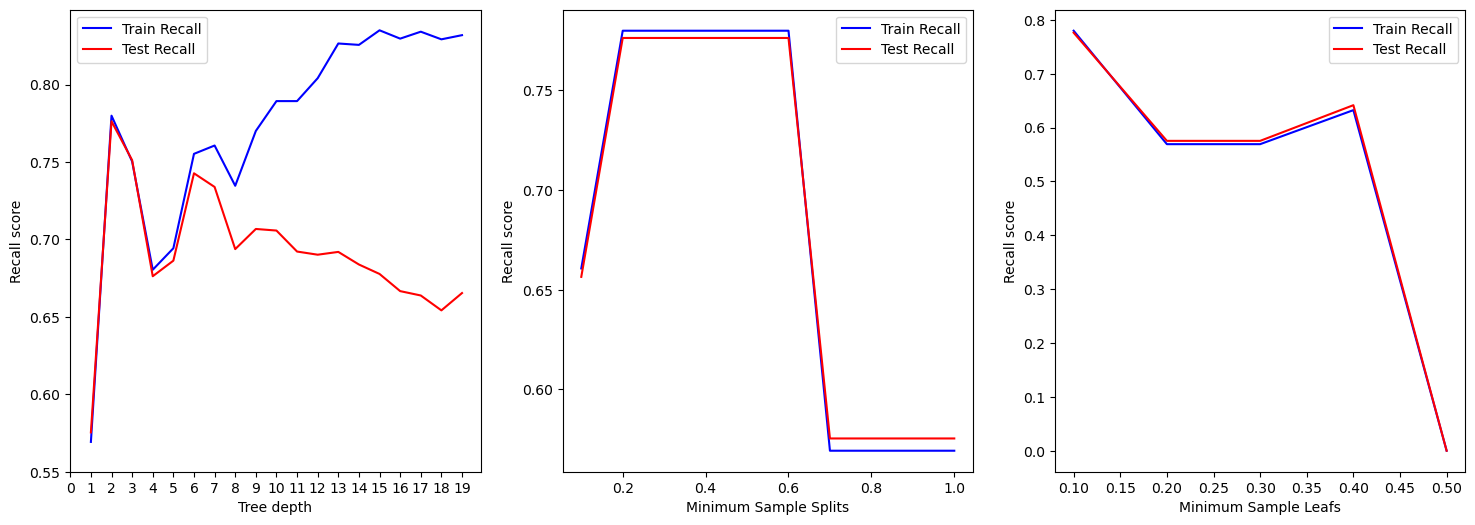

In [26]:
#Plot parameters on multiple subplots
fig, axes = plt.subplots(ncols = 3, figsize = (18,6))

axes[0].plot(max_depth, depth_train_results, 'b', label='Train Recall')
axes[0].plot(max_depth, depth_test_results, 'r', label='Test Recall')
axes[0].set_ylabel('Recall score')
axes[0].set_xlabel('Tree depth')
axes[0].set_xticks(np.arange(0, dt_depth, step=1))
axes[0].set_yticks(np.arange(0.55, 0.85, step=0.05))
axes[0].legend()

axes[1].plot(sample_splits, splits_train_results, 'b', label='Train Recall')
axes[1].plot(sample_splits, splits_test_results, 'r', label='Test Recall')
axes[1].set_ylabel('Recall score')
axes[1].set_xlabel('Minimum Sample Splits')
axes[1].legend()

axes[2].plot(sample_leafs, leafs_train_results, 'b', label='Train Recall')
axes[2].plot(sample_leafs, leafs_test_results, 'r', label='Test Recall')
axes[2].set_ylabel('Recall score')
axes[2].set_xlabel('Minimum Sample Leafs')
axes[2].legend();

Try max depth of 6, minimum sample split of 0.6, and minimum sample leaf value of 0.1.

In [27]:
#Make Decision Tree Model with tuned parameters.
tuned_dtc = DecisionTreeClassifier(random_state = 10,
                            max_depth=6,
                            min_samples_split=0.6,
                            min_samples_leaf=0.1)

#fit to training data
tuned_dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=0.1, min_samples_split=0.6,
                       random_state=10)

In [28]:
#Generate predictions on train and test data
y_hat_train = tuned_dtc.predict(X_train)
y_hat_test = tuned_dtc.predict(X_test)

#calculate recall score on training and test data
print('Tuned Decision Tree - Training Recall: ', recall_score(y_train, y_hat_train))
print('Tuned Decision - Testing Recall: ', recall_score(y_test, y_hat_test))

Tuned Decision Tree - Training Recall:  0.7799193186911699
Tuned Decision - Testing Recall:  0.7762830657924485


In [29]:
#Cross Validate Tuned Decision Tree Model
cv_scores = cross_val_score(tuned_dtc,X_train,y_train,scoring = 'recall')

print(f'Tuned Decision Tree Average Cross Validation Scores: {cv_scores.mean()}')

Tuned Decision Tree Average Cross Validation Scores: 0.7799159318225138


The tuned decision tree model is no longer overfitting to the training data. The validation and training recall scores are nearly identical proving that the model is not overfit. The training recall score is also nearly identical to the test recall score. The model is performing well. This example shows that on the training and test data, it correctly identified 78% of people of someone who received the seasonl flu vaccine.

# Conclusions

## Recommendations

## Limitations

## Next Steps